In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import EfficientNetB2
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import models,layers
from imgaug import augmenters as iaa
import imgaug as ia
from sklearn.metrics import classification_report
import itertools

In [2]:
df = pd.read_csv('../input/isic-2019-challenge/ISIC_2019_Training_GroundTruth.csv')
df_train = pd.read_csv('../input/pastas-de-dados/df_train.csv')
df_val = pd.read_csv('../input/pastas-de-dados/df_val.csv')
df_test = pd.read_csv('../input/pastas-de-dados/df_test.csv')

base_dir = '../input/isic-2019-challenge/ISIC_2019_Training_Input/ISIC_2019_Training_Input'

In [3]:
print(len(df_train))
print(len(df_test))
print(len(df_val))

20264
2533
2534


In [4]:
print(len(df_train[df_train['MEL']==1.0]))
print(len(df_train[df_train['NV']==1.0]))
print(len(df_train[df_train['BCC']==1.0]))
print(len(df_train[df_train['AK']==1.0]))
print(len(df_train[df_train['BKL']==1.0]))
print(len(df_train[df_train['DF']==1.0]))
print(len(df_train[df_train['VASC']==1.0]))
print(len(df_train[df_train['SCC']==1.0]))

3597
10332
2669
695
2095
199
197
480


In [5]:
tf.random.set_seed(42)
ia.seed(42)

rand_aug = iaa.RandAugment(n=6, m=2)

def augment(image):
    image = tf.cast(image, tf.uint8)
    return rand_aug(image=image.numpy())

def random_crop(image,aspect_ratio_range=[0.75, 1.33],area_range=[0.08, 1],min_object_covered=0.5,max_attempts=100,seed=0):
    bbox = tf.constant([0.0, 0.0, 1.0, 1.0], dtype=tf.float32, shape=[1, 1, 4])
    bbox_begin, bbox_size, _ = tf.image.sample_distorted_bounding_box(
    tf.shape(image),
    bounding_boxes=bbox,
    min_object_covered=min_object_covered,
    area_range=area_range,
    aspect_ratio_range=aspect_ratio_range,
    use_image_if_no_bounding_boxes=True,
    max_attempts=max_attempts,
    seed=seed)
    offset_height, offset_width, _ = tf.unstack(bbox_begin)
    target_height, target_width, _ = tf.unstack(bbox_size)

    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.crop_to_bounding_box(image,offset_height,offset_width,target_height,target_width)

    return image

In [6]:
def loadImage(image,mel,nv,bcc,ak,bkl,df,vasc,scc):
 image = tf.io.read_file(base_dir + '/' + image + '.jpg')
 image = tf.io.decode_jpeg(image,channels=3)
 

 label = tf.stack([mel,nv,bcc,ak,bkl,df,vasc,scc])
 return image,label


def dataAument(image,label):
 image = random_crop(image)
 image = tf.image.convert_image_dtype(image, dtype=tf.float32)
 image = tf.image.resize(image,size = (260,260)) #EfficientNetB2
 image = tf.image.random_flip_left_right(image)
 image = tf.image.random_flip_up_down(image)
 image_shape = tf.shape(image)
 image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
 image2 = tf.py_function(augment,[image],[tf.float32])[0]
 image = tf.ensure_shape(image2,shape=image.get_shape())

 return image,label
 
def resize(image,label):
    image = tf.image.resize(image,size = (260,260)) #EfficientNetB0

    return image,label

In [7]:
dataSet_train = tf.data.Dataset.from_tensor_slices((df_train['image'],
                                                    df_train['MEL'],
                                                    df_train['NV'],
                                                    df_train['BCC'],
                                                    df_train['AK'],
                                                    df_train['BKL'],
                                                    df_train['DF'],
                                                    df_train['VASC'],
                                                    df_train['SCC']))
dataSet_train = dataSet_train.shuffle(len(df_train))
dataSet_train = dataSet_train.map(loadImage)
dataSet_train = dataSet_train.map(dataAument)
#dataSet_train = dataSet_train.map(resize)

dataSet_train = dataSet_train.batch(64)

In [8]:
dataSet_val = tf.data.Dataset.from_tensor_slices((df_val['image'],
                                                    df_val['MEL'],
                                                    df_val['NV'],
                                                    df_val['BCC'],
                                                    df_val['AK'],
                                                    df_val['BKL'],
                                                    df_val['DF'],
                                                    df_val['VASC'],
                                                   df_val['SCC']))
dataSet_val = dataSet_val.map(loadImage)
dataSet_val = dataSet_val.map(resize)
dataSet_val = dataSet_val.batch(64)

In [9]:
dataSet_test = tf.data.Dataset.from_tensor_slices((df_test['image'],
                                                    df_test['MEL'],
                                                    df_test['NV'],
                                                    df_test['BCC'],
                                                    df_test['AK'],
                                                    df_test['BKL'],
                                                    df_test['DF'],
                                                    df_test['VASC'],
                                                   df_test['SCC']))
dataSet_test = dataSet_test.map(loadImage)
dataSet_test = dataSet_test.map(resize)
dataSet_test = dataSet_test.batch(64)

(64, 260, 260, 3)


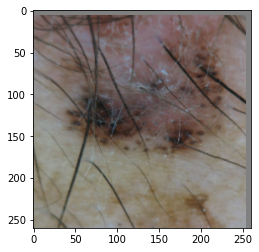

In [10]:
for sample in dataSet_train.take(1):  
  print(sample[0].shape)
  plt.imshow(sample[0][0]/255)
  plt.show()

In [11]:
conv_base = EfficientNetB2(include_top=False,weights='imagenet',input_shape=(260,260,3))

conv_base.summary()

31793152/31790344 [==============================] - 0s 0us/step
Model: "efficientnetb2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 260, 260, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 260, 260, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 260, 260, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 261, 261, 3)  0           normalization[0][0]              
____________________

In [12]:
for layer in conv_base.layers:
  layer.trainable = True
  print(layer.name,layer.trainable)

input_1 True
rescaling True
normalization True
stem_conv_pad True
stem_conv True
stem_bn True
stem_activation True
block1a_dwconv True
block1a_bn True
block1a_activation True
block1a_se_squeeze True
block1a_se_reshape True
block1a_se_reduce True
block1a_se_expand True
block1a_se_excite True
block1a_project_conv True
block1a_project_bn True
block1b_dwconv True
block1b_bn True
block1b_activation True
block1b_se_squeeze True
block1b_se_reshape True
block1b_se_reduce True
block1b_se_expand True
block1b_se_excite True
block1b_project_conv True
block1b_project_bn True
block1b_drop True
block1b_add True
block2a_expand_conv True
block2a_expand_bn True
block2a_expand_activation True
block2a_dwconv_pad True
block2a_dwconv True
block2a_bn True
block2a_activation True
block2a_se_squeeze True
block2a_se_reshape True
block2a_se_reduce True
block2a_se_expand True
block2a_se_excite True
block2a_project_conv True
block2a_project_bn True
block2b_expand_conv True
block2b_expand_bn True
block2b_expand_act

In [13]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(8, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 9, 9, 1408)        7768569   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1408)              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 11272     
Total params: 7,779,841
Trainable params: 7,712,266
Non-trainable params: 67,575
_________________________________________________________________


In [14]:
model.compile(loss="categorical_crossentropy",optimizer='adam',metrics=["acc"])

H = model.fit(dataSet_train,epochs=40,validation_data = dataSet_val)

Epoch 1/40
317/317 [==============================] - 1213s 4s/step - loss: 1.1655 - acc: 0.5876 - val_loss: 0.9127 - val_acc: 0.6744
Epoch 2/40
317/317 [==============================] - 956s 3s/step - loss: 0.8735 - acc: 0.6889 - val_loss: 0.9008 - val_acc: 0.6902
Epoch 3/40
317/317 [==============================] - 905s 3s/step - loss: 0.8038 - acc: 0.7084 - val_loss: 0.7316 - val_acc: 0.7364
Epoch 4/40
317/317 [==============================] - 1199s 4s/step - loss: 0.7387 - acc: 0.7332 - val_loss: 0.7398 - val_acc: 0.7289
Epoch 5/40
317/317 [==============================] - 943s 3s/step - loss: 0.7048 - acc: 0.7445 - val_loss: 0.7169 - val_acc: 0.7399
Epoch 6/40
317/317 [==============================] - 932s 3s/step - loss: 0.6757 - acc: 0.7499 - val_loss: 0.6323 - val_acc: 0.7790
Epoch 7/40
317/317 [==============================] - 919s 3s/step - loss: 0.6435 - acc: 0.7600 - val_loss: 0.7363 - val_acc: 0.7435
Epoch 8/40
317/317 [==============================] - 934s 3s/step 

In [15]:
#Save the entire model to a HDF5 file.
#The '.h5' extension indicates that the model should be saved to HDF5.
model.save('my_modelV2.h5')

In [16]:
#model.load_weights('my_model.h5')

In [17]:
results = model.evaluate(dataSet_test)
print("test loss, test acc:", results)

40/40 [==============================] - 52s 1s/step - loss: 0.6730 - acc: 0.8196
test loss, test acc: [0.6730464100837708, 0.8195815086364746]


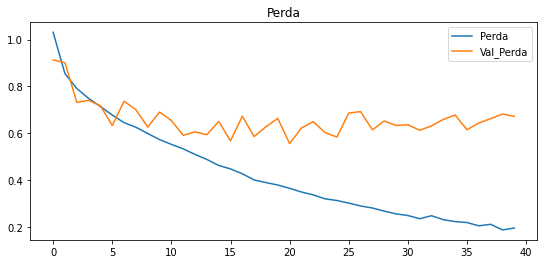

In [18]:
def print_curva(H):
    plt.figure(figsize=(20,4))
    plt.subplot(1,2,2)
    plt.plot(H.history['loss'], label='Perda')
    plt.plot(H.history['val_loss'], label='Val_Perda')
    plt.legend()
    plt.title('Perda')
    plt.show()

    
print_curva(H)

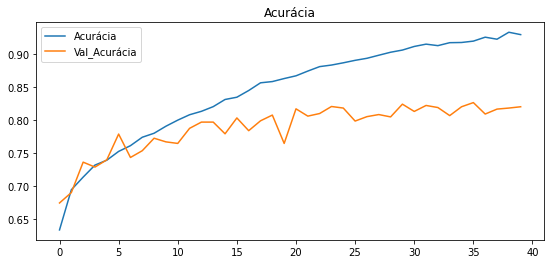

In [19]:
def print_curva2(H):
    plt.figure(figsize=(20,4))
    plt.subplot(1,2,2)
    plt.plot(H.history['acc'], label='Acurácia')
    plt.plot(H.history['val_acc'], label='Val_Acurácia')
    plt.legend()
    plt.title('Acurácia')
    plt.show()


print_curva2(H)

In [20]:
df_true = pd.DataFrame([x for x in np.where(df_test == 1, df_test.columns,'').flatten().tolist() if len(x) > 0], columns= (["dx"]))
true_labels = []
for i in df_true['dx']:
  true_labels.append(i)

n = 0 
for i in true_labels:
  if i == 'MEL':
    true_labels[n] = 0
  if i == 'NV':
    true_labels[n] = 1
  if i == 'BCC':
    true_labels[n] = 2
  if i == 'AK':
    true_labels[n] = 3
  if i == 'BKL':
    true_labels[n] = 4
  if i == 'DF':
    true_labels[n] = 5
  if i == 'VASC':
    true_labels[n] = 6
  if i == 'SCC':
    true_labels[n] = 7
  n += 1

In [21]:
predictions = tf.math.argmax(model.predict(dataSet_test),axis=1)
conf_matrix = tf.math.confusion_matrix(labels=true_labels,predictions=predictions)

In [22]:
array = conf_matrix.numpy()
vet_labels = ['MEL','NV','BCC','AK','BKL','DF','VASC','SCC']

In [23]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Matriz de Confusão',
                          cmap=None,
                          normalize=True):
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('Rótulo Verdadeiro')
    plt.xlabel('Rótulo preditado')
    plt.show()

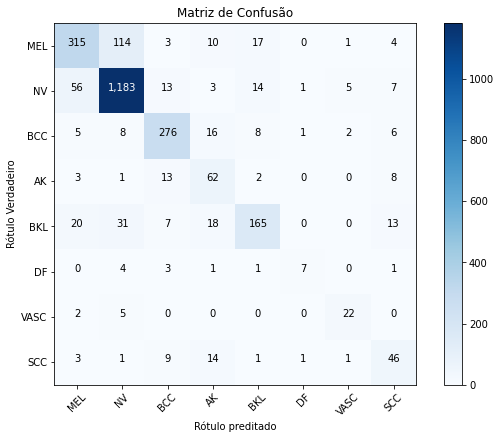

In [24]:
plot_confusion_matrix(array,normalize = False,target_names = vet_labels,title= "Matriz de Confusão")

In [25]:
print(classification_report(true_labels,predictions,target_names=vet_labels))

              precision    recall  f1-score   support

         MEL       0.78      0.68      0.73       464
          NV       0.88      0.92      0.90      1282
         BCC       0.85      0.86      0.85       322
          AK       0.50      0.70      0.58        89
         BKL       0.79      0.65      0.71       254
          DF       0.70      0.41      0.52        17
        VASC       0.71      0.76      0.73        29
         SCC       0.54      0.61      0.57        76

    accuracy                           0.82      2533
   macro avg       0.72      0.70      0.70      2533
weighted avg       0.82      0.82      0.82      2533

